---

## EXTRACTION OF TOPOLOGICAL FEATURES ON AUDIOS FOR CLASSIFICATION

---

1. In the Project-3 folder, you will find two other folders: **Normal** and **Wheezing**. The first folder consists of recorded sound waves of “normal” breathing. The second folder consists of recorded sound waves of breathing with a wheezing sound. This pattern of breathing is generallydetected in the breathing of asthmatic patients.

---

2. The Project-3 folder also contains the notebook **Signal Processing.ipynb.**Your main goal is to adapt this notebook to these new dataset.

---

3. You should create a labeling for the two folders, with files from **Normal labeled 0** and files from **Wheezing labeled 1**. Create a training dataset (about 80% from each class) and testing data set (about 20% from each class.)

---

4. Follow the notebook closely and make your own choices of features se-lection. There are **Persistent Entropy, Carlsson Coordinates** and other methods in the Notebook. Make your own choice (try different choices of these features selection methods and choose the best).

---

### Importing Libraries

---

In [19]:
# data wrangling
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.display import YouTubeVideo
from fastprogress import progress_bar

# hepml
from hepml.core import make_gravitational_waves, download_dataset

# tda magic
from gtda.homology import VietorisRipsPersistence, CubicalPersistence
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.plotting import plot_heatmap, plot_point_cloud, plot_diagram
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding
from gtda.time_series import SingleTakensEmbedding

# ml tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

# dataviz
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))

In [9]:
import tensorflow as tf
import numpy as np
import keras

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate

from math import comb
from collections import Counter
import pickle
import operator
import itertools
from functools import reduce
from tensorflow.keras import Input
from keras import ops

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
from ripser import ripser
from persim import plot_diagrams
from gtda.diagrams import PersistenceEntropy

from sklearn.pipeline import Pipeline
from gtda.diagrams import Amplitude
from gtda.diagrams import NumberOfPoints
from gtda.diagrams import PersistenceEntropy

from sklearn.pipeline import make_pipeline, make_union
#import teaspoon
from teaspoon.ML import feature_functions as Ff

---

### Directory Structure Setup

- The code defines a main folder that contains subfolders, each representing different classes (e.g., different health conditions).

### Randomization and Data Preparation

- It sets a random seed for reproducibility, which ensures that the shuffling of audio files remains consistent across runs.


### Data Splitting

- The audio files are split into training (80%) and testing (20%) sets based on a calculated index, ensuring that each set contains a representative portion of the data.

### Data Structuring

- The paths of the audio files, along with their corresponding labels (derived from folder names), are stored in lists.

---

In [3]:
import os
import random
import pandas as pd

# Define the path to your main folder containing the audio folders
main_folder = '/home/manuella/Desktop/TPA/Project_3/all_data'

# Set the seed for reproducibility
random.seed(42)

# Prepare lists to hold data for train and test sets
train_data = []
test_data = []

# Iterate over each folder in the main folder
for folder_name in os.listdir(main_folder):
    folder_path = os.path.join(main_folder, folder_name)

    if os.path.isdir(folder_path) and folder_name not in ['train', 'test']:
        # List all audio files in the folder
        audio_files = [f for f in os.listdir(folder_path) if f.endswith(('.wav', '.mp3'))]

        # Shuffle the audio files
        random.shuffle(audio_files)

        # Determine the split index
        split_index = int(len(audio_files) * 0.8)

        # Split the audio files into train and test sets
        train_files = audio_files[:split_index]
        test_files = audio_files[split_index:]

        # Append file paths and labels to the respective lists
        for file in train_files:
            train_data.append((os.path.join(folder_path, file), folder_name))  # (file path, label)

        for file in test_files:
            test_data.append((os.path.join(folder_path, file), folder_name))  # (file path, label)

# Create DataFrames for train and test sets
train_df = pd.DataFrame(train_data, columns=['file_path', 'label'])
test_df = pd.DataFrame(test_data, columns=['file_path', 'label'])

# Save the DataFrames as CSV files
train_df.to_csv(os.path.join(main_folder, 'train_dataset.csv'), index=False)
test_df.to_csv(os.path.join(main_folder, 'test_dataset.csv'), index=False)

print("Training and testing datasets have been created and saved as CSV files.")

Training and testing datasets have been created and saved as CSV files.


In [4]:
train_df.head()

,file_path,label
0,/home/manuella/Desktop/TPA/Project_3/all_data/...,Asthma
1,/home/manuella/Desktop/TPA/Project_3/all_data/...,Asthma
2,/home/manuella/Desktop/TPA/Project_3/all_data/...,Asthma
3,/home/manuella/Desktop/TPA/Project_3/all_data/...,Asthma
4,/home/manuella/Desktop/TPA/Project_3/all_data/...,Asthma


**The paths indicate that they are sourced from the specified main folder, suggesting a structured directory of audio data.**

---

---

In [5]:
def fit_embedder(embedder, y, verbose=True):
    y_embedded = embedder.fit_transform(y)

    if verbose:
        print(f"Shape of embedded time series: {y_embedded.shape}")
        print(f"Optimal embedding dimension is {embedder.dimension_} and time delay is {embedder.time_delay_}")

    return y_embedded

def convert_dgm(dgm):
    Arr = dgm.copy()
    Arr[0] = Arr[0][:-1]
    col_a  = np.zeros(Arr[0].shape[0])
    Arr[0] = np.column_stack((Arr[0], col_a))
    
    col_b  = np.ones(Arr[1].shape[0], dtype=int)
    Arr[1] = np.column_stack((Arr[1], col_b))
    temp_1 = list(Arr[0])
    temp_2 = list(Arr[1])
    temp_1.extend(temp_2)
    return np.asarray(temp_1)

---

## Function to extract features

---

In [6]:
import numpy as np
import wave
from sklearn.pipeline import make_union

def extract_features(df):
    features_list = []  # List to store features for each audio file

    for i in range(len(df)):
        file_path = df.iloc[i]['file_path']  
        
        try:
            #Converts to a signal
            spf = wave.open(file_path, "r")
            signal = spf.readframes(-1)
            signal = np.frombuffer(signal, np.int16)

            embedding_dimension = 30
            embedding_time_delay = 100
            stride = 10
            FN = 5

            embedder = SingleTakensEmbedding(
                parameters_type="search", n_jobs=2, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
            )

            y_noise_embedded = fit_embedder(embedder, signal)
            res = ripser(y_noise_embedded, n_perm=700)
            dgms_sub = res['dgms']
            res = convert_dgm(dgms_sub)

            persistence_entropy = PersistenceEntropy()

            # Calculate topological feature matrix
            X_pe = persistence_entropy.fit_transform(res[None, :, :])

            test = dgms_sub[0][:-1]
            test_1 = dgms_sub[1]
            
            # Calculate Carlsson Coordinates

            FeatureMatrix, TotalNumComb, CombList = Ff.F_CCoordinates(test[None, :, :], FN)
            X_cc_0 = FeatureMatrix[-8]

            FeatureMatrix, TotalNumComb, CombList = Ff.F_CCoordinates(test_1[None, :, :], FN)
            X_cc_1 = FeatureMatrix[-9]

            # Listing all metrics we want to use to extract diagram amplitudes
            metrics = [
                {"metric": "bottleneck", "metric_params": {}},
                {"metric": "wasserstein", "metric_params": {"p": 2}},
                {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
                {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
                {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
            ]

            feature_union = make_union(
                PersistenceEntropy(normalize=True),
                NumberOfPoints(n_jobs=-1),
                *[Amplitude(**metric, n_jobs=-1) for metric in metrics]
            )

            single_data = feature_union.fit_transform(res[None, :, :])

            # Combine features
            single_X_train = np.concatenate((X_pe, X_cc_0, X_cc_1, single_data), axis=None)

            # Append the features for this file to the list
            features_list.append(single_X_train)

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            continue  # Skip to the next file in case of an error

    return np.array(features_list)  # Return the features array

## Extraction of features on the train set

In [7]:
df = pd.read_csv('/home/manuella/Desktop/TPA/Project_3/all_data/train_dataset.csv')
X_train = extract_features(df)

Shape of embedded time series: (6044, 19)
Optimal embedding dimension is 19 and time delay is 52
Shape of embedded time series: (9254, 23)
Optimal embedding dimension is 23 and time delay is 73
Shape of embedded time series: (9194, 29)
Optimal embedding dimension is 29 and time delay is 79
Shape of embedded time series: (9264, 29)
Optimal embedding dimension is 29 and time delay is 54
Shape of embedded time series: (8657, 21)
Optimal embedding dimension is 21 and time delay is 59
Shape of embedded time series: (6301, 17)
Optimal embedding dimension is 17 and time delay is 58
Shape of embedded time series: (5362, 13)
Optimal embedding dimension is 13 and time delay is 49
Shape of embedded time series: (5629, 27)
Optimal embedding dimension is 27 and time delay is 48
Shape of embedded time series: (11830, 18)
Optimal embedding dimension is 18 and time delay is 100
Shape of embedded time series: (4671, 8)
Optimal embedding dimension is 8 and time delay is 48
Shape of embedded time series:

Shape of embedded time series: (9445, 12)
Optimal embedding dimension is 12 and time delay is 42
Shape of embedded time series: (4729, 26)
Optimal embedding dimension is 26 and time delay is 72
Shape of embedded time series: (9606, 18)
Optimal embedding dimension is 18 and time delay is 53
Shape of embedded time series: (5687, 15)
Optimal embedding dimension is 15 and time delay is 48
Shape of embedded time series: (5072, 15)
Optimal embedding dimension is 15 and time delay is 48
Shape of embedded time series: (5224, 13)
Optimal embedding dimension is 13 and time delay is 100
Shape of embedded time series: (7984, 12)
Optimal embedding dimension is 12 and time delay is 44
Shape of embedded time series: (10464, 17)
Optimal embedding dimension is 17 and time delay is 48
Shape of embedded time series: (6528, 26)
Optimal embedding dimension is 26 and time delay is 59
Shape of embedded time series: (3897, 10)
Optimal embedding dimension is 10 and time delay is 44
Shape of embedded time serie

### Train features


In [8]:
X_train

array([[9.40892383e+00, 9.33790286e+00, 1.25125211e+11, ...,
        7.26708853e-01, 1.05303707e+00, 7.26708853e-01],
       [9.37242928e+00, 7.49982894e+00, 1.06629641e+11, ...,
        3.13686234e-01, 7.60099197e-01, 3.13686234e-01],
       [9.36883899e+00, 7.89504001e+00, 1.52723259e+11, ...,
        2.16249191e-01, 5.73680199e-01, 2.16249191e-01],
       ...,
       [9.43575875e+00, 9.92775981e+00, 2.93440292e+11, ...,
        6.18233128e-01, 7.18671743e-01, 6.18233128e-01],
       [9.13134707e+00, 8.02114027e+00, 6.39021567e+10, ...,
        8.16645367e-01, 1.22123122e+00, 8.16645367e-01],
       [9.40221404e+00, 8.83305808e+00, 6.83350855e+10, ...,
        6.16733879e-01, 1.07173575e+00, 6.16733879e-01]])

In [10]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/home/manuella/Desktop/TPA/Project_3/all_data/train_dataset.csv')

# Extract training labels
training_labels = data['label']

training_set_s = X_train

#training_set_s = training_set_s.to_numpy()
training_labels = training_labels.to_numpy()

## Extraction of features on the test set

In [11]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/home/manuella/Desktop/TPA/Project_3/all_data/test_dataset.csv')

#df = pd.read_csv('/home/manuella/Desktop/TPA/Project_3/all_data/train_dataset.csv')
X_test = extract_features(data)

# Extract training labels
testing_labels = data['label']

testing_set_s = X_test

#training_set_s = training_set_s.to_numpy()
testing_labels = testing_labels.to_numpy()

Shape of embedded time series: (6675, 24)
Optimal embedding dimension is 24 and time delay is 45
Shape of embedded time series: (7905, 24)
Optimal embedding dimension is 24 and time delay is 100
Shape of embedded time series: (5365, 14)
Optimal embedding dimension is 14 and time delay is 43
Shape of embedded time series: (7810, 13)
Optimal embedding dimension is 13 and time delay is 100
Shape of embedded time series: (7189, 6)
Optimal embedding dimension is 6 and time delay is 48
Shape of embedded time series: (2305, 13)
Optimal embedding dimension is 13 and time delay is 58
Shape of embedded time series: (9188, 11)
Optimal embedding dimension is 11 and time delay is 48
Shape of embedded time series: (8649, 15)
Optimal embedding dimension is 15 and time delay is 90
Shape of embedded time series: (6328, 15)
Optimal embedding dimension is 15 and time delay is 47
Shape of embedded time series: (5811, 26)
Optimal embedding dimension is 26 and time delay is 49
Shape of embedded time series:

### Output Summary

The output consists of a series of statements detailing the results of embedding multiple time series data. Each statement includes:

1. **Shape of Embedded Time Series**:
   - Presented as `(number_of_samples, embedding_dimension)`, indicating how many samples were embedded and into how many dimensions.

2. **Optimal Embedding Dimension and Time Delay**:
   - Specifies the best embedding dimension and the time delay used for the embedding process.

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 34)
rf.fit(training_set_s, training_labels)

#X_test_tda = tda_union.transform(training_set_s)
rf.score(testing_set_s, testing_labels)

0.6585365853658537

---

---

### Output Summary

The output value of `0.6585365853658537` represents the accuracy of the Random Forest Classifier on the testing dataset, indicating that approximately **65.85%** of the predictions were correct.



---

---

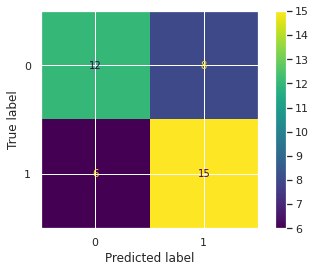

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Train the Random Forest Classifier
rf = RandomForestClassifier(random_state = 34)
rf.fit(training_set_s, training_labels)

# Predict the labels for the test set
predictions = rf.predict(testing_set_s)

# Calculate the confusion matrix
cm = confusion_matrix(testing_labels, predictions)

# Optionally, display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

---

### Confusion Matrix Output Summary

The confusion matrix provides insights into the classification performance of the Random Forest Classifier:

- **Correct Predictions**:
    - Class '0' correctly predicted: **12**
    - Class '1' correctly predicted: **15**

- **Incorrect Predictions**:
    - Class '0' misclassified as '1': **8** (False Positives)
    - Class '1' misclassified as '0': **6** (False Negatives)
    
    
The model is able to well classify the normal and asthma breathing

---

In [17]:
nn = keras.Sequential([
keras.layers.Dense(104, activation='relu',input_shape=(22, ) ),
keras.layers.Dense(56, activation='relu' ),
keras.layers.Dense(28,activation='relu'),
keras.layers.Dense(4,activation='relu'),
#keras.layers.Dense(32,activation='relu'),
keras.layers.Dense(1,activation='relu')])
    
#,kernel_initializer= kernel_combined_1, bias_initializer= bias_combined_1

opt = keras.optimizers.Adam(learning_rate=1e-5, weight_decay=1e-2)
nn.compile(optimizer=opt,loss=keras.losses.BinaryCrossentropy(from_logits=False),\
           metrics=['accuracy'] )

nn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 104)            │         2,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 56)             │         5,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 28)             │         1,596 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           116 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,989 (39.02 KB)

 Trainable params: 9,989 (39.02 KB)

 Non-trainable params: 0 (0.00 B)

---

---

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.4688 - loss: 8.5615 - val_accuracy: 0.4878 - val_loss: 8.2556
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4609 - loss: 8.6875 - val_accuracy: 0.4878 - val_loss: 8.2556
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4714 - loss: 8.5200 - val_accuracy: 0.4878 - val_loss: 8.2556
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4688 - loss: 8.5615 - val_accuracy: 0.4878 - val_loss: 8.2556
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4609 - loss: 8.6875 - val_accuracy: 0.4878 - val_loss: 8.2556
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4714 - loss: 8.5196 - val_accuracy: 0.4878 - val_loss: 8.2556
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4714 - loss: 8.5196 - val_accuracy: 0.4878 - val_loss: 8.2556
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4635 - loss: 8.6455 - val_accuracy: 0.4878 - val_loss: 8.2556

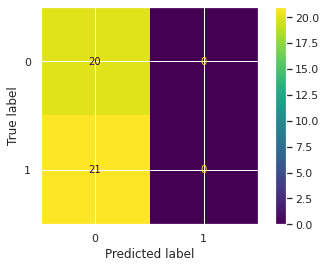

In [18]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming training_labels is a pandas series or list of strings
le = LabelEncoder()
training_labels = le.fit_transform(training_labels)
testing_labels = le.transform(testing_labels)  # Apply the same transformation to test labels

# Ensure they are numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

# Fit the model
nn.fit(x=training_set_s, y=training_labels, validation_data=(testing_set_s, testing_labels), epochs=10, shuffle=True, batch_size=128)

# Make predictions on the testing set
predictions = nn.predict(testing_set_s)
predicted_labels = np.argmax(predictions, axis=1)  # For multi-class classification

# Calculate the confusion matrix
cm = confusion_matrix(testing_labels, predicted_labels)

# Optionally, display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()

### Summary of Neural Network Training (10 Epochs)

- **Epoch Performance**:
  - Training accuracy fluctuated between **0.4688** and **0.4661**, with the highest accuracy in Epoch 3.
  - Validation accuracy remained constant at **0.4878** throughout all epochs.
  - Training loss showed slight variations but did not improve significantly.

### Observations
- The model's performance did not improve over the epochs, indicating potential issues such as overfitting or inadequate model complexity.

- Also the confusion matrix show that the model classify all the data as asthma



### Conclusion

The objective of this project was to extract topological features from audios and train a model capable of classifying each breathing(normal and asthma).

Our results indicate that the 22 features we successfully extracted significantly enhance our ability to classify the data but the test are not really good.

So, we can try to improve the accuracy by adding features. 